# 图像分类数据集（Fashion-MNIST）

在介绍softmax回归的实现前我们先引入一个多类图像分类数据集。它将在后面的章节中被多次使用，以方便我们观察比较算法之间在模型精度和计算效率上的区别。图像分类数据集中最常用的是手写数字识别数据集MNIST [1]。但大部分模型在MNIST上的分类精度都超过了95%。为了更直观地观察算法之间的差异，我们将使用一个图像内容更加复杂的数据集Fashion-MNIST [2]。

## 获取数据集

首先导入本节需要的包或模块。

In [2]:
%matplotlib inline
# import d2ltorch as d2lt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import sys
import time

下面，我们通过torchvision的`datasets`包来下载这个数据集。第一次调用时需要设置`download=True`从网上获取数据, `root`为要下载或者读取数据集的目录。我们通过参数`train`来指定获取训练数据集或测试数据集（testing data set）。测试数据集也叫测试集（testing set），只用来评价模型的表现，并不用来训练模型。

In [3]:
mnist_train = datasets.FashionMNIST(root='~/dataset/', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.FashionMNIST(root='~/dataset/', train=False, download=True, transform=transforms.ToTensor())

100.0%

Extracting /root/dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz


111.0%

Extracting /root/dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz


100.0%

Extracting /root/dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


159.1%

Extracting /root/dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


训练集中和测试集中的每个类别的图像数分别为6,000和1,000。因为有10个类别，所以训练集和测试集的样本数分别为60,000和10,000。

In [5]:
len(mnist_train), len(mnist_test)

(60000, 10000)

我们可以通过方括号`[]`来访问任意一个样本，下面获取第一个样本的图像和标签。

In [6]:
feature, label = mnist_train[0]

如果不用`transform`加载数据集，则数据集中的变量`feature`对应高和宽均为28像素的图像(`PIL.Image.Image`)。  
我们在加载数据时使用了`transforms.ToTensor`, 它会将一个取值范围是[0,255]的PIL.Image或者shape为(H,W,C)的numpy.ndarray，转换成形状为[通道数,高,宽]，取值范围是[0,1.0]的torch.FloadTensor。因为数据集中是灰度图像，所以通道数为1。  
使用`transforms.ToPILImage`可以将shape为(C,H,W)的Tensor或shape为(H,W,C)的numpy.ndarray转换成PIL.Image，值不变。

In [7]:
print(feature.shape, feature.dtype)
transforms.ToPILImage()(feature)

torch.Size([1, 28, 28]) torch.float32


图像的标签使用标量表示。它的类型为32位整数（int）。

In [8]:
label, type(label)

(9, int)

Fashion-MNIST中一共包括了10个类别，分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。以下函数可以将数值标签转成相应的文本标签。

In [9]:
# 本函数已保存在d2ltorch包中方便以后使用
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

下面定义一个可以在一行里画出多张图像和对应标签的函数。

In [10]:
# 本函数已保存在d2ltorch包中方便以后使用
def show_fashion_mnist(images, labels):
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = d2lt.plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.reshape(28, 28).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

现在，我们看一下训练数据集中前9个样本的图像内容和文本标签。

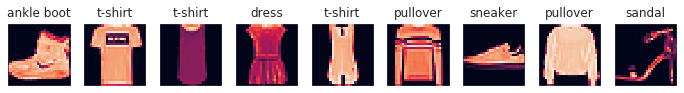

In [11]:
X = [mnist_train[i][0] for i in range(9)]
y = [mnist_train[i][1] for i in range(9)]
show_fashion_mnist(X, get_fashion_mnist_labels(y))

## 读取小批量

我们将在训练数据集上训练模型，并将训练好的模型在测试数据集上评价模型的表现。虽然我们可以像[“线性回归的从零开始实现”](linear-regression-scratch.ipynb)一节中那样通过`yield`来定义读取小批量数据样本的函数，但为了代码简洁，这里我们直接创建`DataLoader`实例。该实例每次读取一个样本数为`batch_size`的小批量数据。这里的批量大小`batch_size`是一个超参数。

在实践中，数据读取经常是训练的性能瓶颈，特别当模型较简单或者计算硬件性能较高时。PyTorch的`DataLoader`中一个很方便的功能是允许使用多进程来加速数据读取（*MXNet的`DataLoader`暂不支持Windows操作系统，PyTorch网上似乎也有人反应这个问题，但我没有测试，所以这里仍然设置win下的进程数为0*）。这里我们通过参数`num_workers`来设置4个进程读取数据。

In [12]:
batch_size = 256
transformer = transforms.ToTensor()
if sys.platform.startswith('win'):
    num_workers = 0 # 0表示不用额外的进程来加速读取数据
else:
    num_workers = 4

train_iter = DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)
test_iter = DataLoader(mnist_test, batch_size, shuffle=False, num_workers=num_workers)

我们将获取并读取Fashion-MNIST数据集的逻辑封装在`d2ltorch.load_data_fashion_mnist`函数中供后面章节调用。该函数将返回`train_iter`和`test_iter`两个变量。随着本书内容的不断深入，我们会进一步改进该函数。它的完整实现将在[“深度卷积神经网络（AlexNet）”](../chapter_convolutional-neural-networks/alexnet.ipynb)一节中描述。

最后我们查看读取一遍训练数据需要的时间。

In [13]:
start = time.time()
for X, y in train_iter:
    continue
'%.2f sec' % (time.time() - start)

'9.01 sec'

## 小结

* Fashion-MNIST是一个10类服饰分类数据集，之后章节里将使用它来检验不同算法的表现。
* 我们将高和宽分别为$h$和$w$像素的图像的形状记为$h \times w$或`（h，w）`。

## 练习

* 减小`batch_size`（如到1）会影响读取性能吗？
* 非Windows用户请尝试修改`num_workers`来查看它对读取性能的影响。
* 查阅PyTorch文档，`torchvision.datasets`里还提供了哪些别的数据集？
* 查阅PyTorch文档，`torchvision.transforms`还提供了哪些别的变换方法？





## 参考文献

[1] LeCun, Y., Cortes, C., & Burges, C. http://yann.lecun.com/exdb/mnist/

[2] Xiao, H., Rasul, K., & Vollgraf, R. (2017). Fashion-mnist: a novel image dataset for benchmarking machine learning algorithms. arXiv preprint arXiv:1708.07747.

## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/7760)

![](../img/qr_fashion-mnist.svg)